In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_cifar_test_files function

from generate_input_files.generate_cifar_test_files import generate_cifar_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_epochs_test")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "performance", "increasing_epochs_test")

# Step 1: Generate CIFAR-10 test files
print("Generating CIFAR-10 test files...")
generated_files = generate_cifar_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

Generating CIFAR-10 test files...
CIFAR-10 images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_definition.yaml
CIFAR-10 images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_definition.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset.zip
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_model.keras
File generation completed.
Dataset zipped t

In [3]:
# --- Refactor: Repeat each experiment multiple times ---
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the epoch counts to test
epoch_counts = [5, 10, 25, 50, 100]

repeat_count = 7  # Number of times to repeat each configuration
all_epoch_results = []  # Store results for all runs

for epochs in epoch_counts:
    for repeat_idx in range(repeat_count):
        print(f"\nSubmitting job with {epochs} epochs (repeat {repeat_idx+1}/{repeat_count})...")

        # Prepare the files and data for the request
        files = {
            "model": open(model_filename, "rb"),
            "dataset": open(dataset_filename, "rb"),
            "dataset_definition": open(yaml_filename, "rb"),
        }
        data = {
            "framework": "TensorFlow 2.16.1",
            "model_name": f"performance_analysis_model_{epochs}_epochs_repeat_{repeat_idx+1}",
            "epochs": epochs,
        }

        # Submit the job
        response = requests.post(API_URL, files=files, data=data)
        print(f"Submitted: {response.status_code} {response.text}")

        # Extract the unique_dir and job_id from the API response
        response_data = response.json()
        unique_dir = response_data.get("unique_dir")
        job_id = response_data.get("job_id")
        if not unique_dir:
            raise ValueError("Error: 'unique_dir' not found in the API response.")

        # Store the mapping for this run
        all_epoch_results.append({
            "epochs": epochs,
            "repeat": repeat_idx + 1,
            "unique_dir": unique_dir,
            "job_id": job_id
        })

        # Wait for the job to finish and download the results
        print(f"Waiting for job with {epochs} epochs (repeat {repeat_idx+1}) to complete...")
        wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
        print(f"Artifacts for {epochs} epochs (repeat {repeat_idx+1}) downloaded to: {DOWNLOAD_DIR}")


Submitting job with 5 epochs (repeat 1/7)...
Submitted: 200 {"job_id":"028d71c4-45c1-4439-8e4d-1bf8cbbfc1b1","status":"Training started","unique_dir":"7c206adc-1e96-4ddd-b18f-cfd234ae5fa1"}
Waiting for job with 5 epochs (repeat 1) to complete...
Checking if job is finished by looking for required files in '7c206adc-1e96-4ddd-b18f-cfd234ae5fa1/output/'...
Still missing files: {'cyclonedx_bom.json', 'metrics.json', 'trained_model.keras', 'logs.log'} and no .link file found
Job is not yet finished. Retrying in 10 seconds...
Submitted: 200 {"job_id":"028d71c4-45c1-4439-8e4d-1bf8cbbfc1b1","status":"Training started","unique_dir":"7c206adc-1e96-4ddd-b18f-cfd234ae5fa1"}
Waiting for job with 5 epochs (repeat 1) to complete...
Checking if job is finished by looking for required files in '7c206adc-1e96-4ddd-b18f-cfd234ae5fa1/output/'...
Still missing files: {'cyclonedx_bom.json', 'metrics.json', 'trained_model.keras', 'logs.log'} and no .link file found
Job is not yet finished. Retrying in 10 s

In [4]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# Define the path to the job result folders
results_dir = DOWNLOAD_DIR  # Use the DOWNLOAD_DIR defined earlier
log_filename = "logs.log"  # Name of the log file in each job folder

# Function to parse a timestamp string into a datetime object
def parse_log_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

# Function to extract timings from a log file
def extract_timings_from_log(log_file_path):
    timings = {}
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if "Training started at UTC" in line:
                timings["training_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "AIBoM generation started at UTC" in line:
                timings["aibom_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "Task completed successfully" in line:
                timings["task_complete"] = parse_log_timestamp(line.split(" - ")[0])
    return timings

# Process each job folder (now using all_epoch_results)
job_timings = []  # Use a list to store job timings

for run in all_epoch_results:
    epochs = run["epochs"]
    repeat = run["repeat"]
    unique_dir = run["unique_dir"]
    job_folder = os.path.join(results_dir, unique_dir)
    log_file_path = os.path.join(job_folder, "output", log_filename)
    
    if os.path.exists(log_file_path):
        print(f"Processing log file for epoch {epochs} (repeat {repeat}): {log_file_path}")
        timings = extract_timings_from_log(log_file_path)
        if "training_start" in timings and "aibom_start" in timings and "task_complete" in timings:
            training_duration = (timings["aibom_start"] - timings["training_start"]).total_seconds()
            aibom_duration = (timings["task_complete"] - timings["aibom_start"]).total_seconds()
            total_duration = (timings["task_complete"] - timings["training_start"]).total_seconds()
            job_timings.append({
                "epochs": epochs,
                "repeat": repeat,
                "training_start": timings["training_start"],
                "training_duration": training_duration,
                "aibom_duration": aibom_duration,
                "total_duration": total_duration,
            })
        else:
            print(f"Warning: Missing timestamps in {log_file_path}")
    else:
        print(f"Warning: Log file not found for epoch {epochs} (repeat {repeat})")

# Convert to DataFrame for aggregation
df = pd.DataFrame(job_timings)

# Aggregate: mean and std for each epoch value
agg_df = df.groupby("epochs").agg({
    "training_duration": ["mean", "std"],
    "aibom_duration": ["mean", "std"],
    "total_duration": ["mean", "std"]
}).reset_index()

# Print aggregated results
print("\nAggregated Timings (Mean ± Std by Epochs):")
print(agg_df)

# Save to CSV
agg_df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_results.csv"), index=False)

# Save non-aggregated raw results to CSV
df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_raw_results.csv"), index=False)

Processing log file for epoch 5 (repeat 1): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\7c206adc-1e96-4ddd-b18f-cfd234ae5fa1\output\logs.log
Processing log file for epoch 5 (repeat 2): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\de2b0b19-f2c3-4d2d-9727-997b561573bf\output\logs.log
Processing log file for epoch 5 (repeat 3): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\53fff7ca-ff64-43a0-9a79-55a3c17dda75\output\logs.log
Processing log file for epoch 5 (repeat 4): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\d1359b97-bc5c-4b19-b48d-9baf63316c0f\output\logs.log
Processing log file for epoch 5 (repeat 5): c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\per

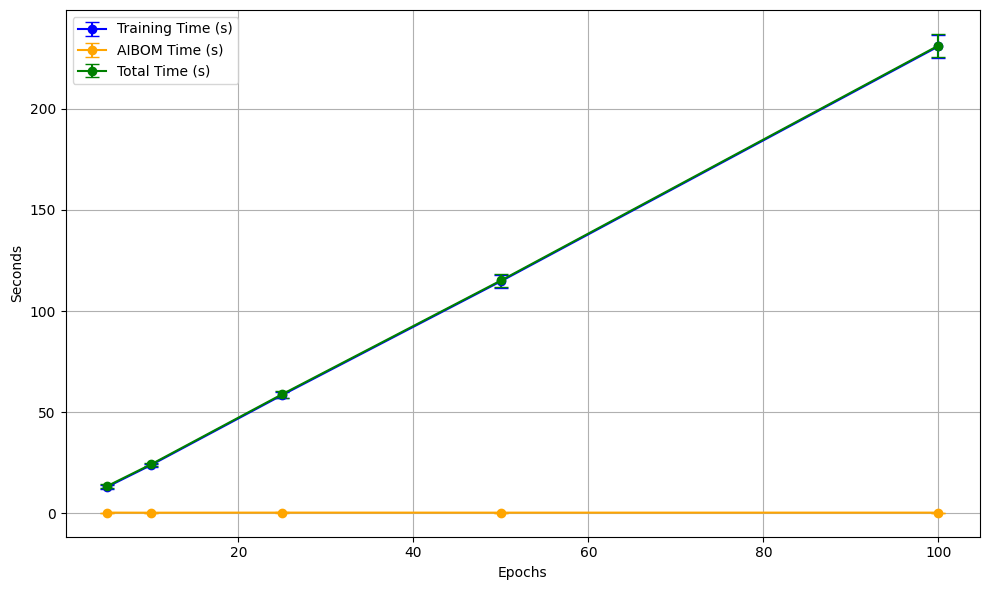

   Epochs  Training Mean (s)  Training Std (s)  AIBOM Mean (s)  AIBOM Std (s)  \
0       5          13.110429          1.109675        0.392143       0.048694   
1      10          23.864571          0.704462        0.351714       0.009178   
2      25          58.501714          1.707833        0.391286       0.086025   
3      50         114.735286          3.167196        0.375286       0.020492   
4     100         230.816571          5.747625        0.383286       0.031663   

   Total Mean (s)  Total Std (s)  
0       13.502571       1.155798  
1       24.216286       0.712091  
2       58.893000       1.756837  
3      115.110571       3.181652  
4      231.199857       5.750777  


In [16]:
# --- Analysis of Aggregated Results ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

agg_csv_path = os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_results.csv")
agg_df = pd.read_csv(agg_csv_path, header=[0,1])
raw_csv_path = os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_raw_results.csv")
raw_df = pd.read_csv(raw_csv_path, header=[0,1])

# Extract columns using multi-row header
epochs = agg_df.iloc[:,0]
training_mean = agg_df[('training_duration', 'mean')]
training_std = agg_df[('training_duration', 'std')]
aibom_mean = agg_df[('aibom_duration', 'mean')]
aibom_std = agg_df[('aibom_duration', 'std')]
total_mean = agg_df[('total_duration', 'mean')]
total_std = agg_df[('total_duration', 'std')]

# Plot mean and std as error bars
plt.figure(figsize=(10, 6))
plt.errorbar(epochs, training_mean, yerr=training_std, fmt='o-', label='Training Time (s)', color='blue', capsize=5)
plt.errorbar(epochs, aibom_mean, yerr=aibom_std, fmt='o-', label='AIBOM Time (s)', color='orange', capsize=5)
plt.errorbar(epochs, total_mean, yerr=total_std, fmt='o-', label='Total Time (s)', color='green', capsize=5)
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_agg_plot.png"))
plt.show()

# Print summary table
summary_df = pd.DataFrame({
    'Epochs': epochs,
    'Training Mean (s)': training_mean,
    'Training Std (s)': training_std,
    'AIBOM Mean (s)': aibom_mean,
    'AIBOM Std (s)': aibom_std,
    'Total Mean (s)': total_mean,
    'Total Std (s)': total_std,
})
print(summary_df)

C:\Users\wiebe\AppData\Local\Temp\ipykernel_18960\2287724904.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(epoch_groups, labels=cleaned_labels, patch_artist=True, showmeans=True, showfliers=False, medianprops=dict(color='blue'), boxprops=dict(facecolor='lightgray'))


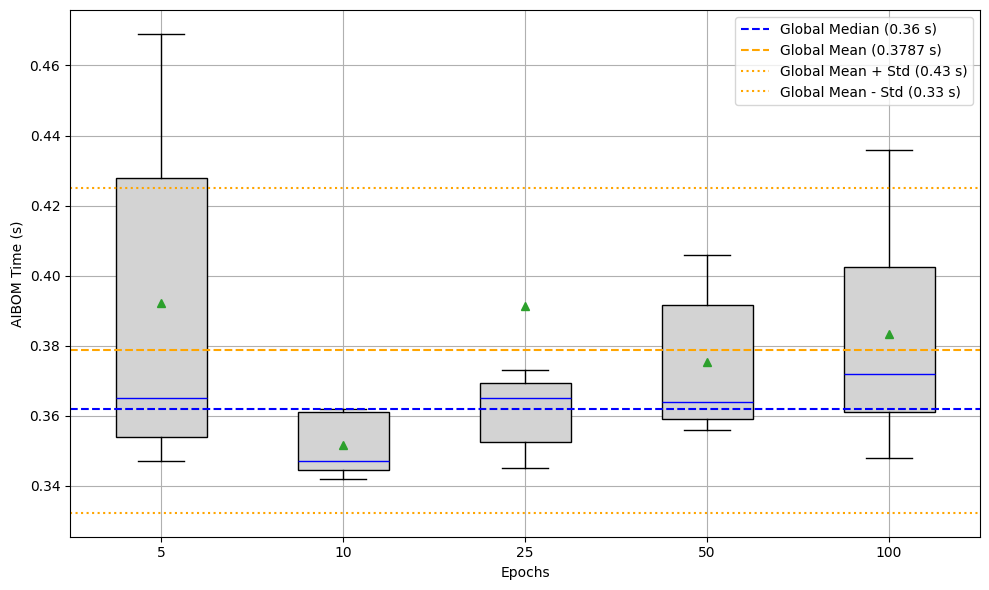

In [11]:
# --- AIBOM Time Analysis: Boxplots per Epoch Count with Mean Overlay (No Outliers, Cleaned) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Load raw results
raw_csv_path = os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_raw_results.csv")
df_raw = pd.read_csv(raw_csv_path)

# Prepare data for boxplot: group by epoch count, remove empty or NaN groups
epoch_labels = sorted(df_raw['epochs'].unique())
epoch_groups = []
cleaned_labels = []
for ep in epoch_labels:
    group = df_raw[df_raw['epochs'] == ep]['aibom_duration'].dropna().values
    if len(group) > 0:
        epoch_groups.append(group)
        cleaned_labels.append(ep)

# Calculate global statistics
all_aibom_times = df_raw['aibom_duration'].dropna()
global_median = np.median(all_aibom_times)
global_mean = np.mean(all_aibom_times)
global_std = np.std(all_aibom_times)

plt.figure(figsize=(10, 6))
# Boxplot for each epoch count, without outliers
box = plt.boxplot(epoch_groups, labels=cleaned_labels, patch_artist=True, showmeans=True, showfliers=False, medianprops=dict(color='blue'), boxprops=dict(facecolor='lightgray'))

# Add global lines
plt.axhline(global_median, color='blue', linestyle='--', label=f'Global Median ({global_median:.2f} s)')
plt.axhline(global_mean, color='orange', linestyle='--', label=f'Global Mean ({global_mean:.4f} s)')
plt.axhline(global_mean + global_std, color='orange', linestyle=':', label=f'Global Mean + Std ({global_mean + global_std:.2f} s)')
plt.axhline(global_mean - global_std, color='orange', linestyle=':', label=f'Global Mean - Std ({global_mean - global_std:.2f} s)')

plt.xlabel('Epochs')
plt.ylabel('AIBOM Time (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "aibom_time_boxplot_mean_overlay.png"))
plt.show()

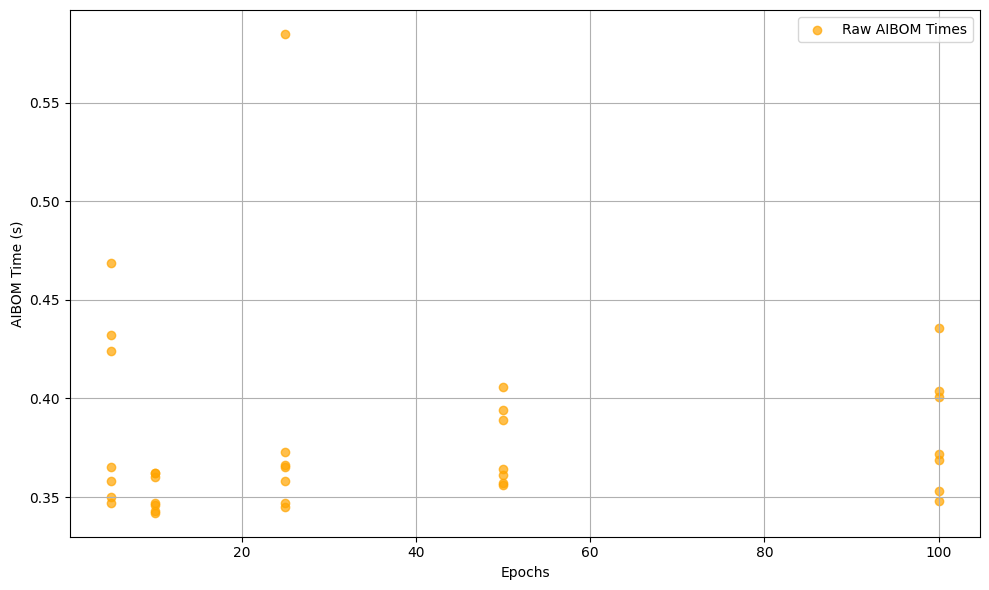

In [14]:
# --- Scatterplot of Raw AIBOM Times vs Epochs ---
import matplotlib.pyplot as plt
import pandas as pd
import os

raw_csv_path = os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_raw_results.csv")
df_raw = pd.read_csv(raw_csv_path)

plt.figure(figsize=(10, 6))
plt.scatter(df_raw['epochs'], df_raw['aibom_duration'], color='orange', alpha=0.7, label='Raw AIBOM Times')

plt.xlabel('Epochs')
plt.ylabel('AIBOM Time (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "aibom_time_raw_scatterplot.png"))
plt.show()

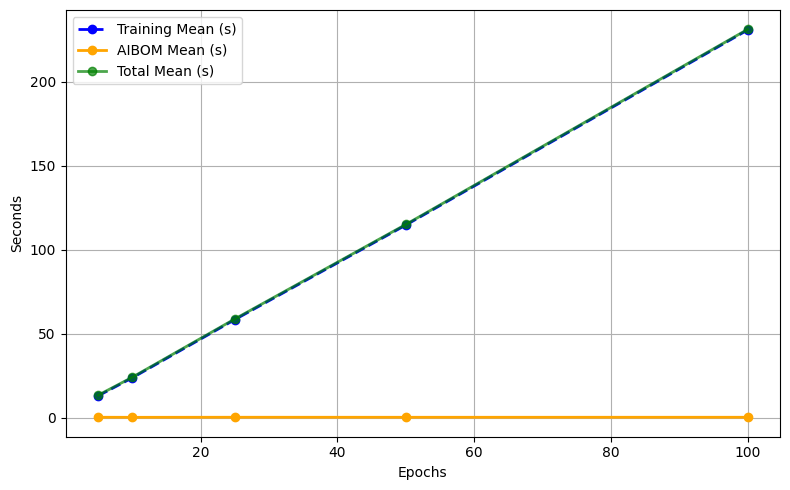

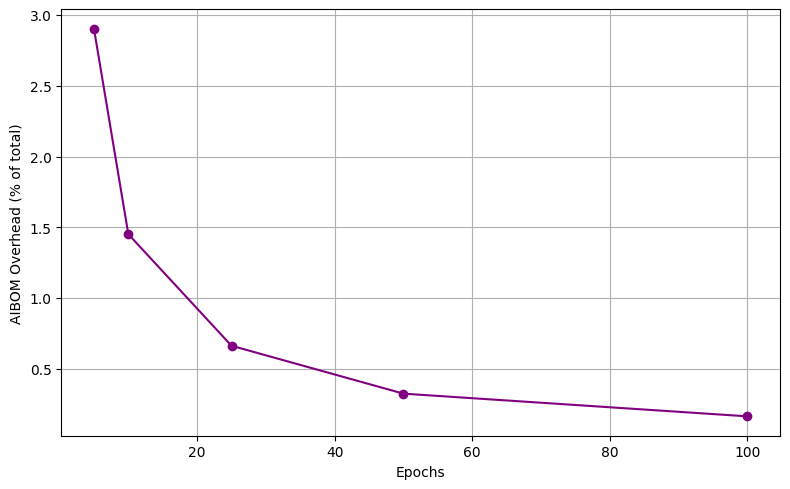

   Epochs  Training Mean (s)  AIBOM Mean (s)  Total Mean (s)  \
0       5          13.110429        0.392143       13.502571   
1      10          23.864571        0.351714       24.216286   
2      25          58.501714        0.391286       58.893000   
3      50         114.735286        0.375286      115.110571   
4     100         230.816571        0.383286      231.199857   

   AIBOM Overhead (%)  
0            2.904209  
1            1.452387  
2            0.664401  
3            0.326022  
4            0.165781  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Convert job_timings to DataFrame for easier aggregation
df = pd.DataFrame(job_timings)

# Group by epochs and calculate means
mean_df = df.groupby('epochs').mean().reset_index()
epochs_list = mean_df['epochs']
training_mean = mean_df['training_duration']
aibom_mean = mean_df['aibom_duration']
total_mean = mean_df['total_duration']

# Plot mean times vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, training_mean, marker='o', label='Training Mean (s)', linestyle='--', color='blue', linewidth=2)
plt.plot(epochs_list, aibom_mean, marker='o', label='AIBOM Mean (s)', linestyle='-', color='orange', linewidth=2)
plt.plot(epochs_list, total_mean, marker='o', label='Total Mean (s)', linestyle='-', color='green', linewidth=2, alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "training_aibom_total_time_plot.png"))
plt.show()

# Plot AIBOM Overhead as Percentage of Total Time (mean values)
overhead_pct = (aibom_mean / total_mean) * 100
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, overhead_pct, marker='o', color='purple', label='AIBOM Overhead (%)')
plt.xlabel('Epochs')
plt.ylabel('AIBOM Overhead (% of total)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOAD_DIR, "aibom_overhead_percentage_plot.png"))
plt.show()

# Print Table
result_df = pd.DataFrame({
    "Epochs": epochs_list,
    "Training Mean (s)": training_mean,
    "AIBOM Mean (s)": aibom_mean,
    "Total Mean (s)": total_mean,
    "AIBOM Overhead (%)": overhead_pct
})
print(result_df)
result_df.to_csv(os.path.join(DOWNLOAD_DIR, "performance_analysis_epoch_results.csv"), index=False)